# Function Fitting Example:

#### <font color="blue"> by: Jeremy Meinke (feel free to contact me here on GitHub, LinkedIn, or email)

This details use of functions found within func_fitting.py, which contains my own custom set of functions for fitting other functions.  Allows for both GLS and noteably Bayesian analysis (which I at least consider to be a pretty cool and relatively quick code).

**Note: This notebook was intially made and run on computer with 16 GB of RAM (~12 GB free or available for this specifically).  Some func_fitting.func_fit() examples here will require a majority of that memory to safely run**
    
Also make sure to see the companion "analysis_example.ipynb" for mm astrononmy functions that would benefit from function fits.


In [1]:
from __future__ import division
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import scipy.integrate as spint
from cycler import cycler
import time
import gc

from analysis_code import func_fitting, astro_analysis

###My personal matplotlib preferences
marker_cycle=["o","^","s","d","X","2","h","v",">"]
color_cycle=["k","b","r","c","orange","m","lime","grey","lavender"]
mpl.rcParams["axes.prop_cycle"] = cycler(color=color_cycle + color_cycle[::-1], marker=marker_cycle*2)

print("Last time run: %s"%time.asctime())

Last time run: Mon Feb  6 15:27:30 2023


(admittedly this isn't a great example for the fit quality itself, but for the fit options)

To start, we'll define a simple polynomial function to do different fitting with.  We'll also define an alternate way to write it in order to showcase the non-linear approach:

In [2]:
def simple_func(x, a, b, c):
    return a*x**2 + b*x + c

def simple_func_alt(x, d, e, f):
    return d*x + e*(x-f)**2

###note that these two equations will both produce 2nd order polynomials, just defined in different ways

###Define "True values", in a way that ensures both functions produce the same results
a_true = e_true = 1
f_true = 5
c_true = e_true * f_true**2
b_true = 1
d_true = b_true + 2*e_true*f_true

###Quick way to print all of them:
for text in ["a", "b", "c", "d", "e", "f"]:
    exec("print('%s_true: ', %s_true)"%(text, text))

a_true:  1
b_true:  1
c_true:  25
d_true:  11
e_true:  1
f_true:  5


Now, let's see what they look like.  They should be identical:

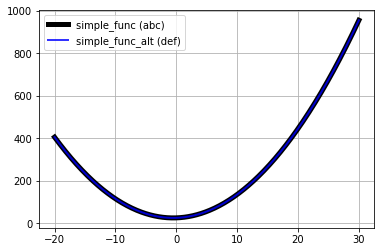

In [3]:
x_range = np.arange(-20, 30.01, 0.1)
plt.plot(x_range, simple_func(x_range, a_true, b_true, c_true), label="simple_func (abc)", marker="",linewidth=5)
plt.plot(x_range, simple_func_alt(x_range, d_true, e_true, f_true), label="simple_func_alt (def)", marker="", linewidth=2, alpha=0.8)
plt.legend()
plt.grid()
plt.show()

#### Generate some fake data (and noise):

x data: 
 [ 16.2  17.5  18.9  -9.1  20.5  28.6 -20.    2.1  25.8  13.9 -13.6 -12.9
   0.9   8.6  18.6]

 y data: 
 [296.44163311 357.91353173 403.84507814  95.70477974 466.05385413
 871.57704347 398.33150678  41.58879187 723.10441275 242.69444563
 189.30644282 179.14192755  31.03126061 103.52674132 363.56626879]


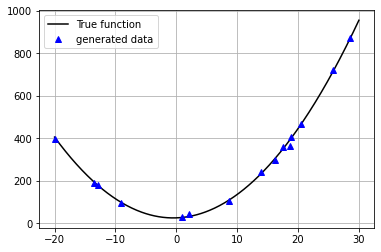

In [4]:
def gen_data(x_range, N=15, noise_sigma=10):
    x_data = np.random.choice(x_range, N, replace=False)
    y_data = simple_func(x_data, a_true, b_true, c_true) + np.random.normal(0, noise_sigma, size=N)
    return x_data, y_data

noise_sigma = 10
x_data, y_data = gen_data(x_range, noise_sigma=noise_sigma)

print("x data: \n", x_data)
print("\n y data: \n", y_data)


plt.plot(x_range, simple_func(x_range, a_true, b_true, c_true), label="True function", marker="")
plt.plot(x_data, y_data, label="generated data", linestyle="")
plt.legend()
plt.grid()
plt.show()

Now that we have our fake data, we can attempt to fit it!  We can do this a handful of ways, namely:
- scipy.optimize.curve_fit: A good method to use in most simple or quick cases.
- func_fitting.func_fit(method="GLS"): Generalized least squares implementation in my custom func_fit code
- func_fitting.func_fit(method="BE"): Bayesian estimation use of func_fitting.  Most helpful in non-linear cases (works for both simple_func and simple_func_alt)

So working through these types in order:

simple_func curve_fit best fit:  [ 0.9915199   1.14585446 25.66284993] 
 simple_func cov: 
 [[ 1.98772531e-04 -1.68983996e-03 -4.36785477e-02]
 [-1.68983996e-03  4.39061956e-02  1.42883277e-01]
 [-4.36785477e-02  1.42883277e-01  1.80312880e+01]]
simple_func_alt curve_fit best fit:  [11.2345067   0.99151991  5.08746834] 
 simple_func_alt cov: 
 [[ 6.97334299e-01 -9.26410872e-03  3.67214758e-01]
 [-9.26410872e-03  1.98772553e-04 -4.83942213e-03]
 [ 3.67214758e-01 -4.83942213e-03  2.00680556e-01]]


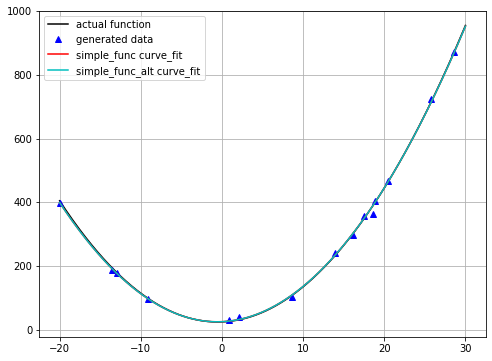

In [5]:
###Curve fits
simple_func_popt, simple_func_popc = curve_fit(simple_func, x_data, y_data, sigma=noise_sigma*np.ones_like(x_data), absolute_sigma=True)
print("simple_func curve_fit best fit: ", simple_func_popt, "\n simple_func cov: \n", simple_func_popc)
simple_func_alt_popt, simple_func_alt_popc = curve_fit(simple_func_alt, x_data, y_data, sigma=noise_sigma*np.ones_like(x_data), absolute_sigma=True)
print("simple_func_alt curve_fit best fit: ", simple_func_alt_popt, "\n simple_func_alt cov: \n", simple_func_alt_popc)

plt.figure(figsize=(8,6))
plt.plot(x_range, simple_func(x_range, a_true, b_true, c_true), label="actual function", marker="")
plt.plot(x_data, y_data, label="generated data", linestyle="")
plt.plot(x_range, simple_func(x_range, *simple_func_popt), label="simple_func curve_fit", marker="")
plt.plot(x_range, simple_func_alt(x_range, *simple_func_alt_popt), label="simple_func_alt curve_fit", marker="")
plt.legend()
plt.grid()
plt.show()


There should be a small but noticeable difference between the curve_fit results and the true function, while the curve_fits of each simple_func vs simple_func_alt shouldn't be noticeably different.

Now for func_fit GLS:

In [6]:
## func_fitting.func_fit() setup
## the fit_range attribute isn't needed for the method="GLS", but will become relevant for method="BE"
a_param = func_fitting.FuncParam("a", "a", np.arange(0.6, 1.401, 0.01), is_linear=True)		## Is linear=True allows for faster computation when such parameter is still linear
b_param = func_fitting.FuncParam("b", "b", np.arange(-1., 3.01, 0.01), is_linear=True)
c_param = func_fitting.FuncParam("c", "c", np.arange(-0., 42.01, 0.05), is_linear=True)

## Note this asks for variance/covariance (for when passing 1d or 2d arrays)
gls_fit, gls_cov = func_fitting.func_fit(simple_func, x_data, y_data, [a_param, b_param, c_param], noise_sigma**2, method="GLS")
print("simple_func GLS best fit: ", gls_fit, "\n simple_func GLS cov: \n", gls_cov)


-----GLS Fitting-----
simple_func GLS best fit:  {'a': 0.9915199060771803, 'b': 1.1458544450014319, 'c': 25.66284929547505} 
 simple_func GLS cov: 
 [[ 1.98772523e-04 -1.68983995e-03 -4.36785444e-02]
 [-1.68983995e-03  4.39062006e-02  1.42883238e-01]
 [-4.36785444e-02  1.42883238e-01  1.80312868e+01]]


This is identical to curve_fit's fit for simple_func, since here they both use the least squares method! 

So what about the BE version?

-----BE Fitting-----


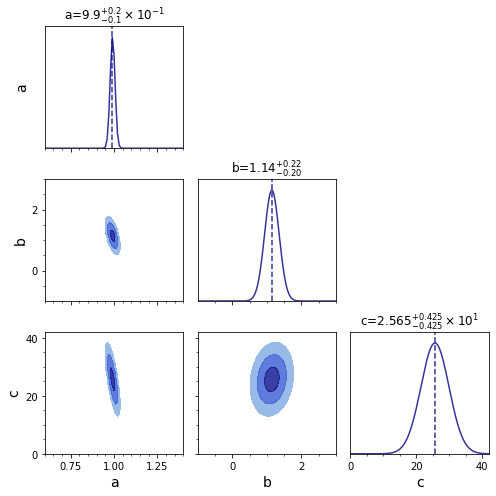

simple_func BE best fit:  {'a': 0.9900000000000003, 'b': 1.140000000000002, 'c': 25.650000000000002} 
 simple_func BE cov: 
 [[ 2.00992997e-04 -1.68062199e-03 -4.36204412e-02]
 [-1.68062199e-03  4.39393424e-02  1.42821334e-01]
 [-4.36204412e-02  1.42821334e-01  1.80148806e+01]]


In [7]:
## We'll also pass quick_corner_plot=True (it's default), showing us the corner plot
simple_func_be_fit, simple_func_be_cov, simple_func_be_1d_bnds, b_bnds, marg_dists = func_fitting.func_fit(simple_func, x_data, y_data, [a_param, b_param, c_param], noise_sigma**2, method="BE", MemoryOverride=False, quick_corner_plot=True, verbose=False)
## verbose=True shows other  values and checks during the computation
print("simple_func BE best fit: ", simple_func_be_fit, "\n simple_func BE cov: \n", simple_func_be_cov)

Notice how chances are the "c" parameter is poorly contrained.  We get similar results to the curve_fit and GLS results above, but are somewhat limited by the fit_range (both range and resolution) capable of being passed.  So what's the benefit here?  Non-linear relations, such as with simple_func_alt: 

(and manipulation of priors and posterior distributions, to be shown later below)

-----BE Fitting-----


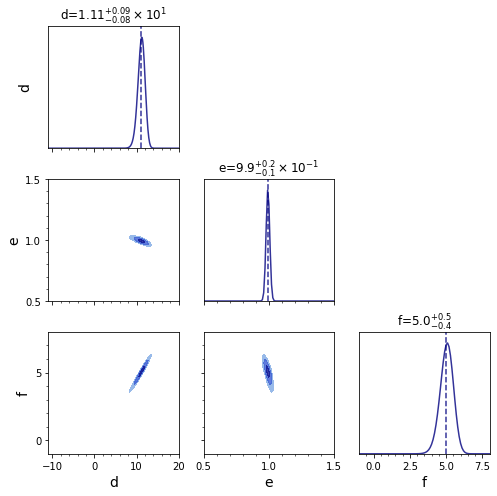

simple_func_alt BE best fit:  {'d': 11.099999999999923, 'e': 0.9900000000000004, 'f': 4.999999999999998} 
 simple_func_alt BE cov: 
 [[ 7.40671446e-01 -9.51656152e-03  3.89163098e-01]
 [-9.51656152e-03  2.05794443e-04 -4.90451020e-03]
 [ 3.89163098e-01 -4.90451020e-03  2.12288242e-01]]


In [8]:
## Note that f_param is not linear here, but passing is_linear=True to the ones that are (d_param and e_param) still allow for faster computation
d_param = func_fitting.FuncParam("d", "d", np.arange(-11., 20.001, 0.1), is_linear=True)
e_param = func_fitting.FuncParam("e", "e", np.arange(0.5, 1.5001, 0.01), is_linear=True)
f_param = func_fitting.FuncParam("f", "f", np.arange(-1., 8.001, 0.1), is_linear=False)
simple_func_alt_be_fit, simple_func_alt_be_cov, simple_func_alt_be_1d_bnds, b_bnds, marg_dists = func_fitting.func_fit(simple_func_alt, x_data, y_data, [d_param, e_param, f_param], noise_sigma**2, method="BE", MemoryOverride=False, quick_corner_plot=True, verbose=False)
print("simple_func_alt BE best fit: ", simple_func_alt_be_fit, "\n simple_func_alt BE cov: \n", simple_func_alt_be_cov)

This time we compare to the simple_func_alt curve_fit from a few blocks above.  They again should be very similar, but affected a bit by the parameter's fit_ranges resolution and limits.  Feel free to adjust these some and see how it changes.  I placed a basic array size check (via MemoryOverride=False) to try to ensure I never bricked my memory (*Cough* totally out of precaution and not because it actually happened multiple times...)

*The corner plot also makes it easy to notice the positive correlation likely present (depending on randomized data points) between parameter fits of d and f.


_Now, about priors_:  Say one parameter is difficult to ascertain, has degeneracy or minimal impact, and various papers simply quote it as a constant to say good enough.  Well, instead of just also calling it a constant while citing those papers that cite those other papers that cite some other papers... we can invoke some sort of prior, such as a Gaussian prior to say we expect it to be near that value, but allow some uncertainty in case it affects our other variables that we care about more.

Here, we'll do it for parameter "d" and try again:

-----BE Fitting-----
At least 1 Prior Weight Provided 



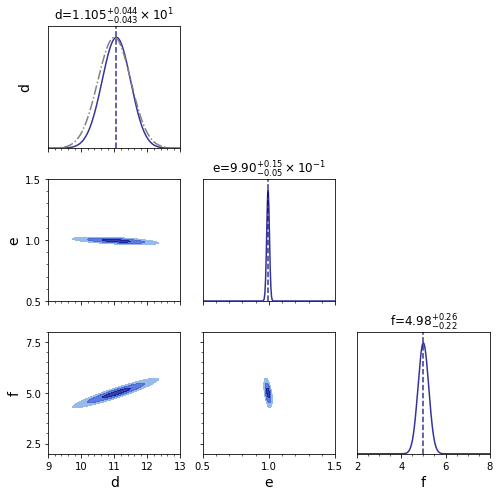

simple_func_alt (d prior) BE best fit:  {'d': 11.05, 'e': 0.9900000000000004, 'f': 4.980000000000002} 
 simple_func_alt (d prior) BE cov: 
 [[ 1.87388471e-01 -2.41752532e-03  9.83854033e-02]
 [-2.41752532e-03  1.20806478e-04 -1.17702669e-03]
 [ 9.83854033e-02 -1.17702669e-03  5.90801858e-02]]


In [9]:
d_param = func_fitting.FuncParam("d", "d", *func_fitting.gaussian_range_prior(d_true, sigma=0.501, step_resolution=0.01, sigma_range=4), is_linear=True)
## It also allows us the ability in this case to zoom in on our other parameters a bit more:
e_param = func_fitting.FuncParam("e", "e", np.arange(0.5, 1.5001, 0.005), is_linear=True)
f_param = func_fitting.FuncParam("f", "f", np.arange(2., 8.01, 0.02), is_linear=False)     ###Note that f is not linear here

simple_func_alt_dprior_be_fit, simple_func_alt_dprior_be_cov, simple_func_alt_dprior_be_1d_bnds, b_bnds, marg_dists = func_fitting.func_fit(simple_func_alt, x_data, y_data, [d_param, e_param, f_param], noise_sigma**2, method="BE", MemoryOverride=False, quick_corner_plot=True, verbose=False)
print("simple_func_alt (d prior) BE best fit: ", simple_func_alt_dprior_be_fit, "\n simple_func_alt (d prior) BE cov: \n", simple_func_alt_dprior_be_cov)

The corner plot is a bit more helpful here, as we can now see the prior distribution assumed for parameter "d".  Depending on the random points generated the actual fit may be shifted slightly negative, indicating that the fit would prefer a lower value than our prior was assuming. How much of a "lean" makes a prior wrong? Well, that would depend upon the parameter and your reasons for assigning a prior.


#### Additional BE Fitting and Plotting:

For my astrophysics purposes, this BE fitting was used for the separation of the tSZ (thermal Sunyaev-Zel'dovich effect) and dust signals present in galaxies stacked at mm wavelengths (see other notebooks).  Here let us quickly assume two sets of SPT-like measurements and apply our BE fitting technique to them both:

**Mentioned in the other notebooks, SPT bands cover a range of frequencies and the tSZ+dust function thus requires a multi-dimensional input "frequency band" values.  For any such functions with multi-dimensional input x-values, I recommend testing and double checking *prior to BE fitting* that any higher-dimensional input would produce the still desired results. (func_fitting.func_fit() stacks the x_values on it's last dimension prior to the fitting process)

In [10]:
## Loading SPT bandpasses, and ensuring they're the same length (important when passing through func_fit)
spt_freqs = [95, 150, 220]
spt_bp_name = "GHz_SPT_Filter.txt"
spt_bandpasses = [np.genfromtxt("./data/" + str(f) + spt_bp_name) for f in spt_freqs]
print(spt_bandpasses[1].shape)
## For passing through fitting functions, each frequency bandpass would need to be the same size.  You can do this by filling zeros at their uppermost frequency
maxlen=max([len(i) for i in spt_bandpasses])
for i in range(3):
	bp_len = len(spt_bandpasses[i])
	print("SPT %iGHz old len: "%spt_freqs[i], bp_len)	###notice how they're different lengths to start with
	if bp_len < maxlen:
		extra = np.column_stack([spt_bandpasses[i][-1,0]+np.arange(maxlen-bp_len)+1,np.zeros(maxlen-bp_len)])
		spt_bandpasses[i]=np.vstack([spt_bandpasses[i], extra])
	print("new len: ", len(spt_bandpasses[i]))

## Some generic values one might observe, ex1 meant to shift Beta down a bit, ex2 shifts Beta up a bit
spt_example1 = np.array([-5e-5, -0.5e-5, 8e-5]) 			## Units of T_CMB [Kelvin]
spt_example2 = np.array([-9e-5, -4e-5, 12e-5]) 			## Units of T_CMB [Kelvin]
spt_vars = np.array([1e-10, 8e-11, 1e-10])				## This would in reality be a 3x3 covariance matrix

## Values we used
beta_dust = 1.75  	## [unitless]
beta_dust_std = 0.25## [unitless]
t_dust = 20    		## [K]
t_dust_std = 3		## [K]
z = 1			   	## redshift [unitless]

## FuncParams:
dust_params = [func_fitting.FuncParam("beta_dust", r"$\beta_{\rm d}$", *func_fitting.gaussian_range_prior(beta_dust, beta_dust_std, 0.05, sigma_range=4.)), func_fitting.FuncParam("t_dust", r"T$_{\rm d}$", *func_fitting.gaussian_range_prior(t_dust, t_dust_std, 0.5, sigma_range=4.))]
spt_ex1_signal_params = [func_fitting.FuncParam("y", r"$y$", fit_range=np.arange(1, 45.001, 0.5)*1e-6, is_linear=True), func_fitting.FuncParam("dust_intensity", r"I$_{\rm r}(\nu_{\rm 0})$", fit_range=np.arange(1, 75.001, 1)*1e-23, is_linear=True)]
spt_ex2_signal_params = [func_fitting.FuncParam("y", r"$y$", fit_range=np.arange(1, 45.001, 0.5)*1e-6, is_linear=True), func_fitting.FuncParam("dust_intensity", r"I$_{\rm r}(\nu_{\rm 0})$", fit_range=np.arange(1, 75.001, 1)*1e-23, is_linear=True)]
constant_params = {"z" : z}
return_margs = [[(dust_params+spt_ex1_signal_params)[i].func_name, (dust_params+spt_ex1_signal_params)[j].func_name] for i in range(4) for j in range(i+1, 4)]
print("2d Marginal distributions to return: ",return_margs)

(71, 2)
SPT 95GHz old len:  99
new len:  99
SPT 150GHz old len:  71
new len:  99
SPT 220GHz old len:  62
new len:  99
2d Marginal distributions to return:  [['beta_dust', 't_dust'], ['beta_dust', 'y'], ['beta_dust', 'dust_intensity'], ['t_dust', 'y'], ['t_dust', 'dust_intensity'], ['y', 'dust_intensity']]


-----BE Fitting-----
At least 1 Prior Weight Provided 



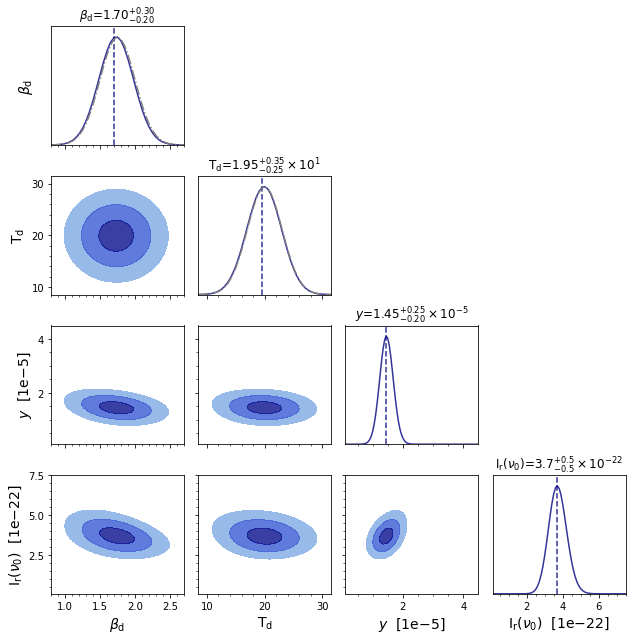

In [11]:
## Now to do the fitting, (I'll be requesting within_n_dim_bnds = [2] for a later plot and return_margs defined above)

spt_ex1_be_fit, spt_ex1_be_cov, spt_ex1_1d_bnds, spt_ex1_b_bnds, spt_ex1_marg_dists = func_fitting.func_fit(astro_analysis.tsz_dust_over_band, [s.T for s in spt_bandpasses], spt_example1, 
dust_params+spt_ex1_signal_params, spt_vars, method="BE", MemoryOverride=False, quick_corner_plot=True, verbose=False, within_n_dim_bnds=[2], return_marg_dists=return_margs, **constant_params)

-----BE Fitting-----
At least 1 Prior Weight Provided 



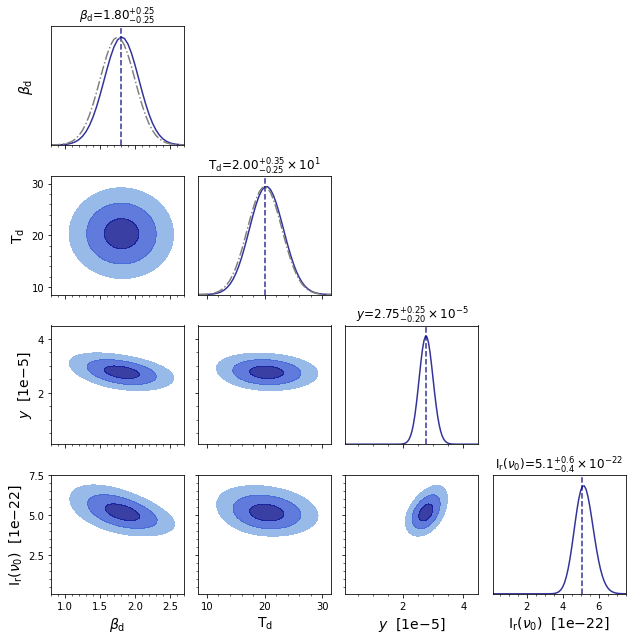

In [12]:
## Now the second example
spt_ex2_be_fit, spt_ex2_be_cov, spt_ex2_1d_bnds, spt_ex2_b_bnds, spt_ex2_marg_dists = func_fitting.func_fit(astro_analysis.tsz_dust_over_band, [s.T for s in spt_bandpasses], spt_example2, 
dust_params+spt_ex2_signal_params, spt_vars, method="BE", MemoryOverride=False, quick_corner_plot=True, verbose=False, within_n_dim_bnds=[2], return_marg_dists=return_margs, **constant_params)

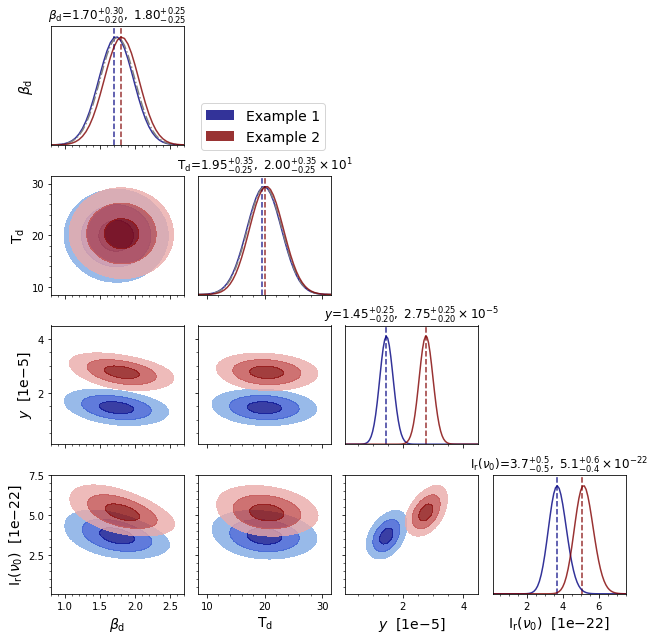

In [13]:
## So as an example, I'll now put them together on the sample corner plot
cmaps = [mpl.colors.LinearSegmentedColormap.from_list("", ["white", "lightblue", "royalblue", "navy"]), mpl.colors.LinearSegmentedColormap.from_list("", ["white", "mistyrose", "indianred", "maroon"])]
func_fitting.cornerplot_from_margs([dust_params+spt_ex1_signal_params, dust_params+spt_ex2_signal_params], [spt_ex1_marg_dists, spt_ex2_marg_dists], legend_names=["Example 1", "Example 2"], bnds_2d=[1, 2, 3], best_fits=[spt_ex1_be_fit, spt_ex2_be_fit], show_fit_1sigmas=True, cmaps=cmaps, verbose=False)

So the func_fitting.cornerplot_from_margs instance also allows for multiple corner plots at a time.  Though I'd advice setting show_fit_1sigmas=False, as the label titles can get rather crowded.  And as always, feel free to edit the base code if something else is preferred.  I often just use these functions for quick displays. Then for final publication-quality plots I copy the function and edit it to further meet my needs.

Similarly, we can plot the frequency responses and utilize the n-dimensional sigma bound outputs (spt_ex1_b_bnds and spt_ex2_b_bnds) to shade a region around the best fit via func_fitting.cont_bnds_func_fitted():

In [14]:
freqs = np.arange(1, 300)
## Note how the n-dimensional sigma bounds are output as a dictionary of dictionary elements (in case multiple sigmas are given)
print("n-dim bound key: ", spt_ex1_b_bnds.keys())
print("n-dim bound dictionary within: ", spt_ex1_b_bnds["2.0 $\\sigma$"])
spt_ex1_lower, spt_ex1_upper = func_fitting.cont_bnds_func_fitted(astro_analysis.y_and_dust_to_mJy, freqs, spt_ex1_b_bnds["2.0 $\\sigma$"], ["y", "dust_intensity"], **constant_params)
spt_ex2_lower, spt_ex2_upper = func_fitting.cont_bnds_func_fitted(astro_analysis.y_and_dust_to_mJy, freqs, spt_ex2_b_bnds["2.0 $\\sigma$"], ["y", "dust_intensity"], **constant_params)

n-dim bound key:  dict_keys(['2.0 $\\sigma$'])
n-dim bound dictionary within:  {'beta_dust': array([1.25, 1.25, 1.25, ..., 2.2 , 2.2 , 2.2 ]), 't_dust': array([19.5, 20. , 20. , ..., 22. , 22. , 22. ]), 'y': array([1.60e-05, 1.60e-05, 1.60e-05, ..., 1.35e-05, 1.40e-05, 1.40e-05]), 'dust_intensity': array([4.1e-22, 4.0e-22, 4.1e-22, ..., 3.4e-22, 3.3e-22, 3.4e-22])}


SPT Band Centers:  [ 97.46502039 153.38490331 219.80659521]


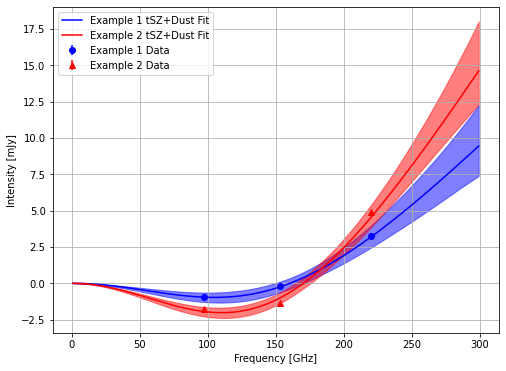

In [20]:
## Grabbing SPT band centers
spt_bandcenters = np.array([spint.simps(spt_bandpasses[f][:,0]*spt_bandpasses[f][:,1], spt_bandpasses[f][:,0]) / spint.simps(spt_bandpasses[f][:,1], spt_bandpasses[f][:,0]) for f in range(3)])
print("SPT Band Centers: ", spt_bandcenters)

plt.figure(figsize=(8,6))
## Example 1
plt.plot(freqs, astro_analysis.y_and_dust_to_mJy(freqs, **spt_ex1_be_fit, **constant_params), color="b", label="Example 1 tSZ+Dust Fit", marker="")
plt.errorbar(spt_bandcenters, astro_analysis.uK_to_mJy(spt_bandcenters, spt_example1*1e6), spt_vars**(0.5), color="b", linestyle="", label="Example 1 Data")
plt.fill_between(freqs, spt_ex1_lower, spt_ex1_upper, color="b", alpha=0.5)
## Example 2
plt.plot(freqs, astro_analysis.y_and_dust_to_mJy(freqs, **spt_ex2_be_fit, **constant_params), color="r", label="Example 2 tSZ+Dust Fit", marker="")
plt.errorbar(spt_bandcenters, astro_analysis.uK_to_mJy(spt_bandcenters, spt_example2*1e6), spt_vars**(0.5), color="r", linestyle="", label="Example 2 Data")
plt.fill_between(freqs, spt_ex2_lower, spt_ex2_upper, color="r", alpha=0.5)

plt.xlabel("Frequency [GHz]")
plt.ylabel("Intensity [mJy]")
plt.legend()
plt.grid()
plt.show()

## THE END!

This has covered everything significant in func_fitting.py and the final notebook out of the three that I have planned discussing my work.  As always, feel free to grab whatever functions you deem beneficial to make your own and contact me if you have any questions!